<a href="https://colab.research.google.com/github/juanandres-montero/macroeconometria/blob/main/Laboratorio_09_Cambio_Estructural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<link rel="stylesheet" type="text/css"
    href="https://cdn.rawgit.com/dreampulse/computer-modern-web-font/master/fonts.css">
<style>
body {
  font-family: "Computer Modern Sans", sans-serif;
}
h1, h3 {
  font-weight: bold;
}
</style>

<center>
  <img src="https://github.com/juanandres-montero/microeconometria/blob/main/logo%20EEC%20grande.png?raw=1" width="396" height="161">
  <h1></h1>
  <h1 style="text-align: center;">EC-4301 MACROECONOMETRÍA</h1>
  <h2 style="text-align: center;">Asist. Juan Andrés Montero Zúñiga</h2>
  <br>
  <h3> Laboratorio 09:</h3>
  <div style="font-size:250%;color:white; background-color: #0064b0;">Cambio Estructural</div>
</center>
<br><br>

<i>
    Creado: 2024-Jun
</i>

<hr>

# Prueba de Chow

Limpieza y carga de datos:

In [152]:
!wget https://github.com/juanandres-montero/macroeconometria/raw/main/oil_test.xlsx
import pandas as pd
df = pd.read_excel("/content/oil_test.xlsx", sheet_name="Hoja3")

--2024-07-02 10:58:43--  https://github.com/juanandres-montero/macroeconometria/raw/main/oil_test.xlsx
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/juanandres-montero/macroeconometria/main/oil_test.xlsx [following]
--2024-07-02 10:58:43--  https://raw.githubusercontent.com/juanandres-montero/macroeconometria/main/oil_test.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19705 (19K) [application/octet-stream]
Saving to: ‘oil_test.xlsx.8’

oil_test.xlsx.8     100%[===================>]  19.24K  --.-KB/s    in 0.001s  

2024-07-02 10:58:43 (35.9 MB/s) - ‘oil_test.xlsx.8’ saved [19705/19705]


Conversión de variables a formato numérico:

In [153]:
df = df.apply(pd.to_numeric, errors='coerce')

Generación de nuevas variables:

In [154]:
import numpy as np
df['Gas_per_capita'] = df['GasExp'] / df['Pop'] / df['Gasp']
df['t'] = df['Year'] - 1952 # tendencia centrada en 1952
df['lngpc'] = np.log(df['Gas_per_capita'])
df['lnincome'] = np.log(df['Income'])
df['lnpg'] = np.log(df['Gasp'])
df['lnpnc'] = np.log(df['PNC'])
df['lnpuc'] = np.log(df['PUC'])
df['cons_percapita_millon'] = df['Gas_per_capita'] * 1_000_000#consumo per cápita de gasolina.

Gráfico de dispersión del consumo per cápita de gasolina:

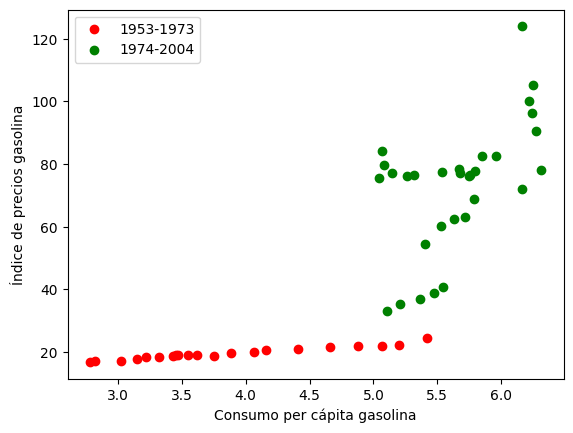

In [155]:
import matplotlib.pyplot as plt

plt.scatter(df[df['Year'] <= 1973]['cons_percapita_millon'], df[df['Year'] <= 1973]['Gasp'], color='red', label='1953-1973')
plt.scatter(df[df['Year'] > 1973]['cons_percapita_millon'],df[df['Year'] > 1973]['Gasp'] , color='green', label='1974-2004')
plt.legend()
plt.xlabel('Consumo per cápita gasolina')
plt.ylabel('Índice de precios gasolina')
plt.show()

Regresión para diferentes períodos:

In [156]:
import statsmodels.api as sm

X = df[['lnincome', 'lnpg', 'lnpnc', 'lnpuc', 't']]
X = sm.add_constant(X)
y = df['lngpc']

model_full = sm.OLS(y, X).fit()
S = model_full.ssr  # Suma de residuos al cuadrado (SSR)
#print(model_full.summary())
print(f"S = {S}")

model_pre1974 = sm.OLS(y[df['Year'] < 1974], X[df['Year'] < 1974]).fit()
S_pre1974 = model_pre1974.ssr  # SSR
print("\nRegresión 1953-1973:")
#print(model_pre1974.summary())
print(f"S_2 (1953-1973) = {S_pre1974}")

model_post1973 = sm.OLS(y[df['Year'] > 1973], X[df['Year'] > 1973]).fit()
S_post1973 = model_post1973.ssr  # SSR
print("\nRegresión 1974-2004:")
#print(model_post1973.summary())
print(f"S_2 (1974-2004) = {S_post1973}")

S = 0.10199695859910016

Regresión 1953-1973:
S_2 (1953-1973) = 0.002022444723752553

Regresión 1974-2004:
S_2 (1974-2004) = 0.0071278986860849125


Cálculo y decisión estadística:

In [157]:
# Cálculo del estadístico de Chow
from scipy.stats import f
n1 = len(df[df['Year'] < 1974])
n2 = len(df[df['Year'] > 1973])
k = 6  # Número de coeficientes
S2 = S_pre1974 + S_post1973
T = len(df)

F_statistic = ((S-S2) / k) / (S2 / (T - (2 * k)))
critical_value = f.ppf(0.99, k, T - (2 * k))
p_value = 1-f.cdf(F_statistic, k, T - (2 * k))

print(f"\nEstadístico F: {F_statistic}")
print(f"Valor crítico F(99%, {k}, {T - 2 * k}): {critical_value}")
print(f"p-valor: {p_value}")
if abs(F_statistic) > abs(critical_value):
    print("Rechazamos la hipótesis nula. Hay un cambio estructural.")
else:
    print("No rechazamos la hipótesis nula. No hay un cambio estructural.")


Estadístico F: 67.64526825623032
Valor crítico F(99%, 6, 40): 3.2910123892986864
p-valor: 1.1102230246251565e-16
Rechazamos la hipótesis nula. Hay un cambio estructural.


In [158]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

#@markdown ### Obtener datos del precio de la plata para Costa Rica
url = "https://www.cpcalc.com/cpc/api/currency/historical.php?from=XAG&to=CRC"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df[0])
    df.sort_values(by='date', inplace=True)
    df1 = df
    fecha_inicio = '2007-05-17'
    fecha_fin = pd.Timestamp.today().normalize()
    fechas_diarias = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
    df1.index = fechas_diarias[:len(df1)]
    df2 = df1[[1]]
    df2 = df2.rename(columns={1: 'Precio'})
    df2 = df2['2016-01-01':'2021-10-31']
    nuevo_indice = pd.date_range(start='2016-08-20', periods=len(df2), freq='D')
    df2.index = nuevo_indice


else:
    print(f"Error al obtener los datos. Código de respuesta: {response.status_code}")
df2.head()

,Precio
2016-08-20,10364.058254
2016-08-21,10342.812990
2016-08-22,10299.392673
2016-08-23,10312.229424
2016-08-24,10452.666073


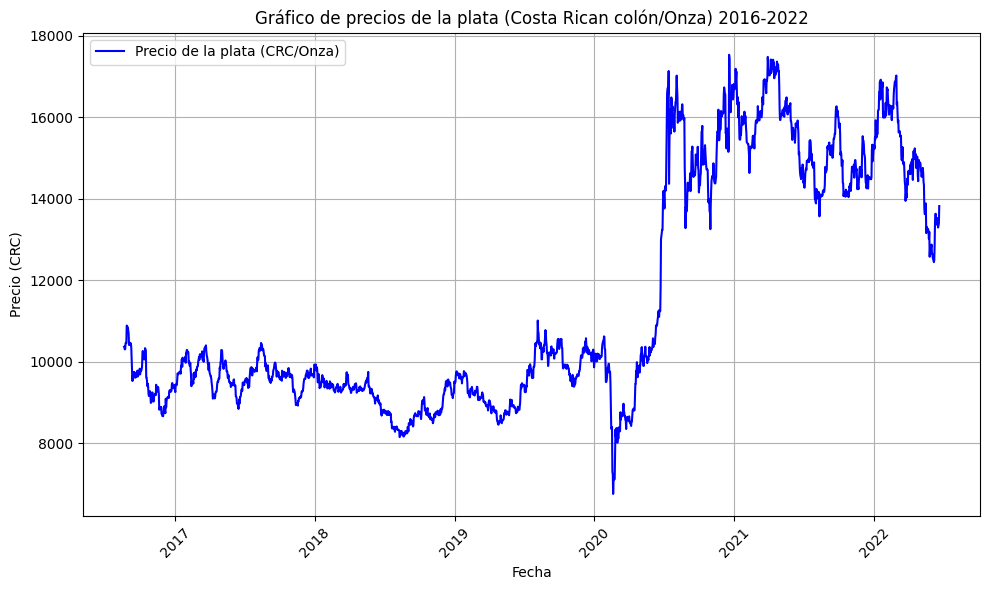

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(df2['Precio'], linestyle='-', color='b', label='Precio de la plata (CRC/Onza)')
plt.title('Gráfico de precios de la plata (Costa Rican colón/Onza) 2016-2022')
plt.xlabel('Fecha')
plt.ylabel('Precio (CRC)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [161]:
df2.to_csv("precio_plata.csv")

from google.colab import files
files.download('precio_plata.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<a href="https://colab.research.google.com/github/juanandres-montero/macroeconometria/blob/main/Laboratorio_10_VAR.ipynb">Siguiente laboratorio>>></a>